In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import os
import scipy as sp
root = '/mnt/cube/tsainbur/Experiments/ephys_analysis/B1169/MDA'
import pickle
matplotlib.rcParams.update({'font.size': 18})


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
loc_dat1 = root + '/Spikes_B1169_left_AP2500_ML500_Z1450.pickle'
fid1 = open(loc_dat1,'rb')
spks = pickle.load(fid1)
#loc_dat2 = loc_dat + 'trials.pickle'
loc_dat2 = root + '/trial-data_B1169_left_AP2500_ML500_Z1450.pickle'
fid2 = open(loc_dat2,'rb')
trials = pickle.load(fid2)

In [4]:
stim_lab = list(trials['stimulus'])
good = [i[:2]!='CL' for i in stim_lab]
grid_trials = trials[good]
grid_trials
stim_lab = list(grid_trials['stimulus'])

In [5]:
# TSa
grid_trials['stim_points'] = [[float(j.replace('d', '.')) for j in i.split('_')] for i in grid_trials['stimulus'].values]
stim_locs = np.stack(grid_trials['stim_points'].values)
stim_locs

/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[ -7.5     , -12.5     ],
       [ -5.625   ,  -6.875   ],
       [-14.375   ,  -4.375   ],
       ..., 
       [ -1.796875,  -8.828125],
       [ -2.578125,   1.953125],
       [ -1.953125,   3.359375]])

In [6]:
d_loc = '/home/AD/tsheehan/data/all_points.npy'
dat2 = np.load(d_loc)
dat2 = np.transpose(dat2)

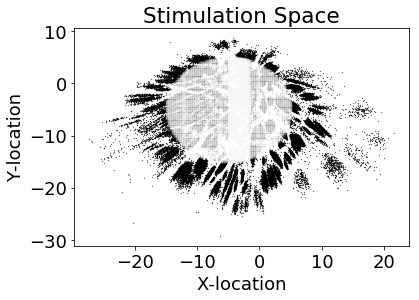

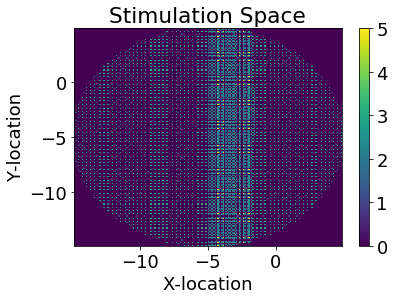

In [7]:
stim_labels = list(grid_trials.stim_points)
stim_labels = np.stack(grid_trials.stim_points)
plt.plot(dat2[0],dat2[1],'k.',markersize=.5)
plt.plot(stim_labels[:,0],stim_labels[:,1],'w.',alpha=.1)

plt.xlabel('X-location')
plt.ylabel('Y-location')
plt.title('Stimulation Space')
plt.show()

plt.hist2d(stim_labels[:,0],stim_labels[:,1],bins=200)
plt.xlabel('X-location')
plt.ylabel('Y-location')
plt.title('Stimulation Space')
plt.colorbar()
plt.show()

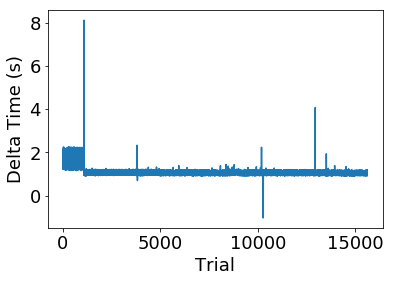

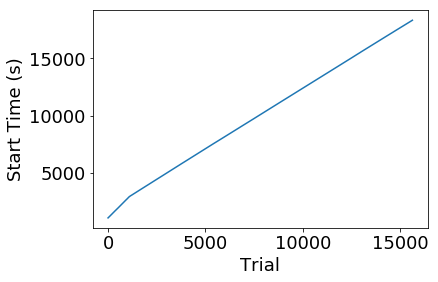

In [8]:
st_times = np.array(grid_trials['time_samples'].values)/40000
d_times = np.array(st_times[1:]-st_times[:-1])
plt.plot(d_times)
plt.xlabel('Trial')
plt.ylabel('Delta Time (s)')
plt.show()

plt.plot(st_times)
plt.xlabel('Trial')
plt.ylabel('Start Time (s)')
plt.show()

In [9]:
lTrial = 2000
def cluster_sum(spks,trials,clust_use=3,x_use=14):
    lTrial = 2000
    if not 'lTrial' in globals():
        lTrial = len(trials)
    # trials
    stim_labels = list(trials.stim_points)
    stim_labels = np.stack(trials.stim_points)
    st_time = np.array(trials[:lTrial].time_samples)
    ed_time = np.array(trials[:lTrial].stimulus_end)
    stim_len = ed_time[0] - st_time[0]
    print(stim_len)
    #spikes
    clust = list(set(spks.cluster))
    unit_use = clust[clust_use] #3
    spk_times = np.array(spks[spks.cluster==unit_use].time_samples)
    my_spikes = np.zeros(np.max(spk_times)+1,dtype=int)
    my_spikes[spk_times] = int(1)
    st_time = np.array(trials[:lTrial].time_samples)
    # sort latent space
    x_pts = stim_labels[:lTrial,0]
    y_pts = stim_labels[:lTrial,1]
    x_val = np.unique(x_pts)
    y_val = np.unique(y_pts)
    # get PSTH
    x_use = x_pts[x_use] # 6
    pts_want = x_pts==x_use
    pre_offset = -10*1000
    PSTH = spks_in_win(my_spikes,st_time[pts_want]+pre_offset,40*1000)
    # sort by y-location
    spk_loc = np.where(PSTH>=1)
    spk_loc = [x+pre_offset for x in spk_loc]
    val_pts_want = np.where(np.array(pts_want))
    probe_y = y_pts[pts_want]

    # ISI
    ISI = get_ISI(spk_times)
    ISI = ISI[ISI<40*40]
    too_soon = np.round(np.mean(ISI<min_thresh)*100,2)
    
    # plotting
    plt.figure(figsize=(6,4))
    plt.subplot(1,2,1)
    plt.hist(ISI/40,50)
    plt.xlabel('ISI (ms)')
    plt.ylabel('Count')
    plt.title('Below min: ' + str(too_soon) + '%')
    
    plt.subplot(1,2,2)
    plt.hist(spk_loc[0],30)
    yl = np.squeeze([plt.gca().get_ylim()])
    plt.plot([0, 0],yl,'r--')
    plt.plot([stim_len, stim_len],yl,'r--')
    plt.title('Cluster:'+ str(unit_use))
    
    

In [10]:
# check time distribution of events
#trials
# GET PSTH for a given set of windows
def spks_in_win(spks,st_time,win_len):
    #st_time[st_time>len(spks)] = []
    st_time = np.delete(st_time,np.where(st_time>len(spks)))
    n_trials = len(st_time)
    PSTH = np.zeros((win_len,n_trials))
    for i in range(n_trials):
        this_win = np.arange(st_time[i],st_time[i]+win_len)
        PSTH[:,i] = spks[this_win]
    return PSTH
def get_ISI(spk_times):
    d_spk = spk_times[1:]-spk_times[:-1]
    return d_spk
min_thresh = 2*40 # 2 ms

20085


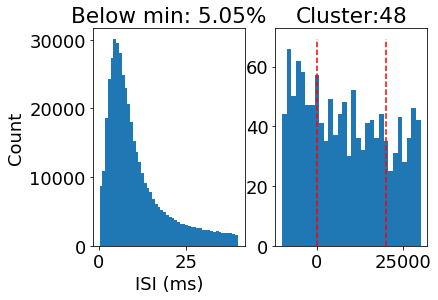

In [41]:
cluster_sum(spks,grid_trials,clust_use=11,x_use=45)

In [12]:
good_units = np.array([0,3,5,11,16])

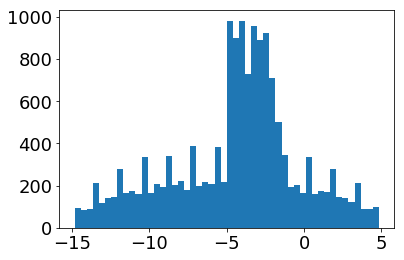

In [13]:
# N x val per X point
np.shape(stim_labels)
x_val = [x[0] for x in stim_labels ]
plt.hist(x_val,50)
plt.show()
#np.unique(x_val)

In [14]:
def gauss_val(x,sd=1,mu=0):
    y1 = -((x-mu)**2)/(2*sd**2)
    y = (2*np.pi*sd)**-0.5*np.exp(y1)
    return y

stp  = .02
x = np.arange(-10,10,.01)
gauss_kern = gauss_val(x,5)

def get_spk_vectors(clusts_use=[3,4],do_conv = False):
    pre_offset = -0*1000
    len_get = 15
   
    stim_labels = list(trials_use.stim_points)
    stim_labels = np.stack(trials_use.stim_points)
    st_time = np.array(trials_use.time_samples)
    ed_time = np.array(trials_use.stimulus_end)
    stim_len = ed_time[0] - st_time[0]
    
    clust = list(set(spks.cluster))
    spk_loc_all = list()
    if do_conv:
        conv_all = list()
    for clust_use in clusts_use:
        print('Processing: ',clust_use)
        # spike times to raster
        unit_use = clust[clust_use]
        spk_times = np.array(spks[spks.cluster==unit_use].time_samples)
        my_spikes = np.zeros(np.max(spk_times)+1,dtype=int)
        my_spikes[spk_times] = int(1)
        PSTH = spks_in_win(my_spikes,st_time+pre_offset,len_get*1000)
        
        spk_loc = np.where(PSTH>=1)
        spk_loc = [x+pre_offset for x in spk_loc]
        spk_loc_all.append(spk_loc)
        if do_conv:
            conv_out = PSTH # convolve changes input (I think)
            for i in range(np.shape(conv_out)[1]):
                conv_out[:,i] = np.convolve(conv_out[:,i],gauss_kern,'same')
        if do_conv:
            conv_all.append(conv_out)
    if do_conv:
        return spk_loc_all,conv_all
    return spk_loc_all

In [65]:
#spk_vec_a = get_spk_vectors(good_units[:2])
lTrial = 1000
trials_use = grid_trials[:lTrial]
spk_vec,conv_vec = get_spk_vectors(good_units[:4],do_conv=True)

Processing:  0
Processing:  3
Processing:  5
Processing:  11


In [70]:
lTrial = 2000
trials_use = grid_trials[:lTrial]
spk_vec_more = get_spk_vectors(good_units[:4],do_conv=False)

Processing:  0
Processing:  3
Processing:  5
Processing:  11


In [98]:
lTrial = 2000
trials_use = grid_trials[:lTrial]
spk_vec_all = get_spk_vectors(np.arange(18),do_conv=False) # all units
# clust = list(set(spks.cluster))
# len(clust)

Processing:  0
Processing:  1
Processing:  2
Processing:  3
Processing:  4
Processing:  5
Processing:  6
Processing:  7
Processing:  8
Processing:  9
Processing:  10
Processing:  11
Processing:  12
Processing:  13
Processing:  14
Processing:  15
Processing:  16
Processing:  17


In [99]:
spk_vec = spk_vec_all
tot_spks = np.zeros((len(spk_vec),lTrial))
for i in range(len(spk_vec)):
    tot_spks[i,:] = [np.sum(spk_vec[i][1]==x) for x in range(lTrial)]
    #tot_spks[i,:] = [len(spk_vec[i][1])]

In [72]:
foo = spk_vec[3][1]
len(foo)
lTrial
np.shape(tot_spks)
tot_spks[0][:15]
spk_vec[0][0]

array([    0,     0,     1, ..., 14997, 14997, 14998])

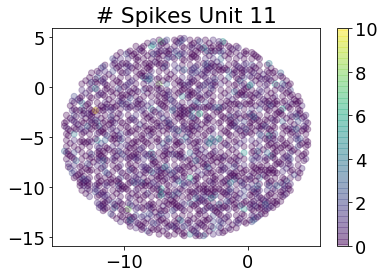

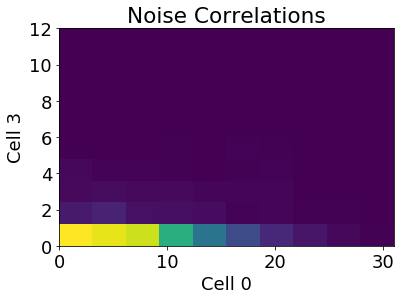

In [100]:
loc = np.transpose(np.stack(trials_use['stim_points']))
spk_view_ind = 3
this_spk = tot_spks[spk_view_ind] #3,1600
avg_spk = np.mean(tot_spks,axis=0)

plt.scatter(loc[0],loc[1],c=this_spk,alpha=.3,vmax = 10)
plt.title('# Spikes Unit '+ str(good_units[spk_view_ind]))
plt.colorbar()
plt.show()

plt.hist2d(tot_spks[0],tot_spks[3])
plt.xlabel('Cell 0')
plt.ylabel('Cell 3')
plt.title('Noise Correlations')
plt.show()

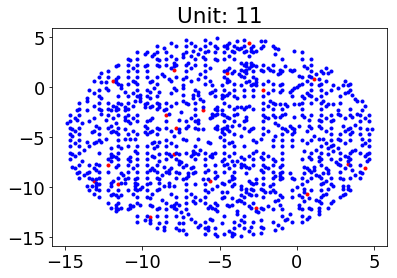

In [74]:
spk_view_ind = 3
this_spk = tot_spks[spk_view_ind] #3,1600

high = this_spk>50 #25//5
low = this_spk<20

plt.plot(loc[0][high],loc[1][high],'r.')
plt.plot(loc[0][low],loc[1][low],'b.')
plt.title('Unit: ' + str(good_units[spk_view_ind]))
plt.show()


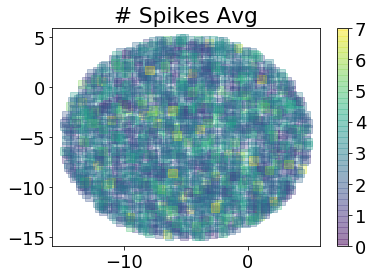

In [106]:
avg_spk = np.mean(tot_spks,axis=0)
#plt.subplot('111', axisbg='black')
plt.scatter(loc[0],loc[1],c=avg_spk,alpha=.3,marker='s',s=70,vmax = 7,vmin = 0)

plt.title('# Spikes Avg')
plt.colorbar()
plt.show()


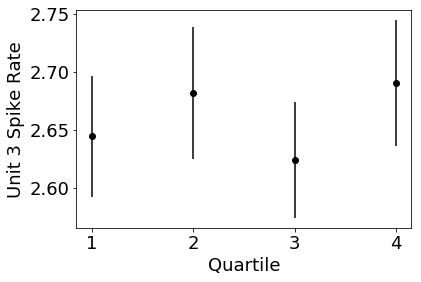

In [108]:
# subdivide locs
# quartiles
Q1 = (loc[0]>-5) & (loc[1]>-5)
Q2 = (loc[0]<-5) & (loc[1]>-5)
Q3 = (loc[0]<-5) & (loc[1]<-5)
Q4 = (loc[0]>-5) & (loc[1]<-5)
#print(np.mean(Q1),np.mean(Q2),np.mean(Q3),np.mean(Q4))
#var_use = avg_spk
ind = 3
var_use = tot_spks[ind]
var_use = np.mean(tot_spks,axis=0)
spks_Q = np.array([np.mean(var_use[Q1]),np.mean(var_use[Q2]),np.mean(var_use[Q3]),np.mean(var_use[Q4])])
spks_Q_e = np.array([std_err(var_use[Q1]),std_err(var_use[Q2]),std_err(var_use[Q3]),std_err(var_use[Q4])])
plt.figure()
plt.errorbar(np.arange(4)+1, spks_Q, yerr=spks_Q_e,c='k',fmt='o')
plt.xlabel('Quartile')
#plt.ylabel('Avg Spike Rate')
plt.ylabel('Unit ' + str(ind) + ' Spike Rate')
plt.show()

In [81]:
def std_err(x):
    return np.std(x)/np.sqrt(len(x))

In [82]:
mx_rate = np.max(conv_vec,axis=1)
mx_time = np.argmax(conv_vec,axis=1)/40000

avg_mx_rate = np.mean(mx_rate,axis=0)
avg_mx_time = np.mean(mx_rate,axis=0)

plt.scatter(loc[0],loc[1],c=avg_mx_rate,alpha=.6,marker='o',s=70)
plt.title('Max Rate')
plt.colorbar()
plt.show()

plt.scatter(loc[0],loc[1],c=avg_mx_time,alpha=.6,marker='o',s=70)
plt.title('Max Time')
plt.colorbar()
plt.show()

NameError: name 'conv_vec' is not defined

In [109]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
t_trial = trials_use['time_samples'].values


In [110]:
#np.shape(mx_rate)
#var_in = np.transpose(np.concatenate([tot_spks,mx_time])) # also see: mx_time, tot_spks
var_in = np.transpose(tot_spks)
out = pca.fit(var_in) # n_samples x n_features
pca_space = out.transform(var_in)

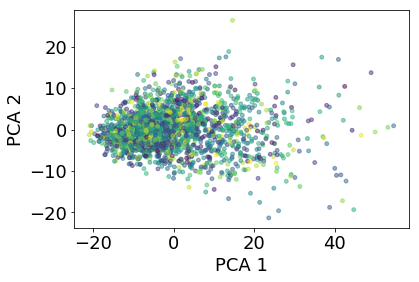

array([ 0.64421391,  0.12657013])

In [115]:
foo = np.transpose(pca_space)

plt.scatter(foo[0],foo[1],c=loc[1],s =15,alpha=.5) # c = t_trial, loc[1]
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()
out.explained_variance_ratio_

In [133]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
X = np.transpose(tot_spks)
Y = np.transpose(loc)

# diabetes_X_train = diabetes_X[:-20]
# diabetes_X_test = diabetes_X[-20:]
train_ind = np.arange(1900)
test_ind = np.arange(1900,2000)

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X[train_ind], Y[train_ind]) #n_samples x n_features
Y_pred = regr.predict(X[test_ind])
Y_true = Y[test_ind]
# print(np.shape(X),np.shape(Y),np.shape(Y_pred))

(2000, 18) (2000, 2) (100, 2)


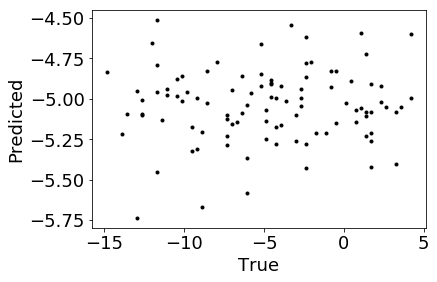

Help on LinearRegression in module sklearn.linear_model.base object:

class LinearRegression(LinearModel, sklearn.base.RegressorMixin)
 |  Ordinary least squares Linear Regression.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : boolean, optional, default True
 |      whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (e.g. data is expected to be already centered).
 |  
 |  normalize : boolean, optional, default False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subtracting the mean and dividing by the l2-norm.
 |      If you wish to standardize, please use
 |      :class:`sklearn.preprocessing.StandardScaler` before calling ``fit`` on
 |      an estimator with ``normalize=False``.
 |  
 |  copy_X : boolean, optional, default True
 |      If True, X will be copied; else, it may be overwritten.
 |

In [138]:
foo = np.transpose(Y_true)
bar = np.transpose(Y_pred)
plt.plot(foo[0],bar[0],'k.')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()
help(regr)

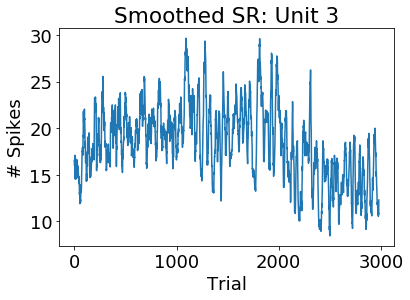

In [69]:
box = np.ones(20)
box = box/sum(box)
ind = 3
spk_smth = np.convolve(tot_spks[ind],box,mode='valid')

plt.plot(spk_smth)
plt.xlabel('Trial')
plt.ylabel('# Spikes')
plt.title('Smoothed SR: Unit ' + str(ind))
plt.show()
# help(np.convolve)

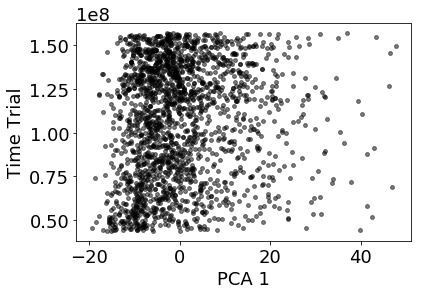

In [92]:
plt.scatter(foo[0],t_trial,c='k',s =15,alpha=.5)
plt.xlabel('PCA 1')
plt.ylabel('Time Trial')
plt.show()

In [188]:
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(foo[0],t_trial)
#adjusted_mutual_info_score(foo[1],t_trial)

0.0

In [169]:
np.shape(var_in)

(1000, 8)

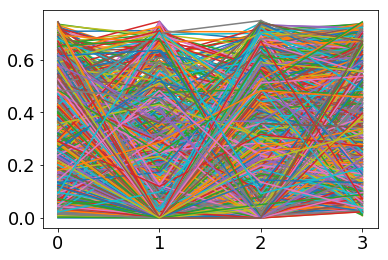

In [191]:
plt.plot(mx_time)
plt.show()